In [1]:
import pennylane as qml
import torch
from pennylane import numpy as np
from matplotlib import pyplot as plt
from torch.optim import Adam
from torch.autograd import Variable

In [2]:
!pip install pylatexenc


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: /opt/conda/envs/pennylane/bin/python3 -m pip install --upgrade pip


In [3]:
def rotation_layer(w):
    for i in range(num_qubits):
        qml.RY(w[i], wires=i)

In [4]:
def entangling_block(w):
    for i in range(num_qubits):
        qml.CZ(wires = [i, (i+1)%num_qubits])

In [5]:
# define classical discriminator
from torch import nn

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

In [6]:
# generate data
from scipy.stats import lognorm, norm, triang
import matplotlib.pyplot as plt

def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def generate_data(which = "log-normal", num_discrete_values = 8):
    
    x = np.linspace(0,7, num_discrete_values)
    
    if which == "log-normal":
        rv = lognorm.pdf(x, 1)
    elif which == "triangular":
        """
        triangular distribution with:
            lower limit l = 0
            upper limit u = 7
            mode m = 2
        """
        a = 0
        b = 7
        mode = 2
        list_of_candidates = range(a, b+1)
        rv = triang.pdf(x, mode/(b-a), a, b)
        
        
    else: #bimodal
        """
        bimodal distribution with:
            two superimposed Guassian distributions with
            mu_1 = 0.5
            sigma_1 = 1
            
            mu_2 = 3.5
            sigma_2 = 0.5
        """
        gauss1 = norm.pdf(x, 0.5, 1)
        gauss2 = norm.pdf(x, 3.5, 0.5)
        rv = (gauss1 + gauss2) / (np.sum(gauss1) + np.sum(gauss2))
        
        
    # fig, ax = plt.subplots(1, 1)
    # ax.plot(x, rv,'r-', lw=5, alpha=0.6, label='lognorm pdf')
    
    return x, rv
    
    
generate_data(which="triangular", num_discrete_values = 16)

(tensor([0.        , 0.46666667, 0.93333333, 1.4       , 1.86666667,
         2.33333333, 2.8       , 3.26666667, 3.73333333, 4.2       ,
         4.66666667, 5.13333333, 5.6       , 6.06666667, 6.53333333,
         7.        ], requires_grad=True),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.26666667, 0.24      , 0.21333333, 0.18666667, 0.16      ,
        0.13333333, 0.10666667, 0.08      , 0.05333333, 0.02666667,
        0.        ]))

In [7]:
# #create generator + discriminator

# print(qml.draw(generator, show_matrices=True)(params))
# print(params)

In [8]:
# cost function
def gen_loss(x): # maximize the discriminator misclassifying fake data
    # print(f"gen loss input: {x}")
    loss = torch.log(x) 
    # loss = torch.log(1 - x)
    # print(f"loss: {loss}")
    return -loss

def disc_loss(real, fake): # log(real) = maxed when disc correctly classifies real data; log(1 - fake) = maxed when disc correctly classifies fake data
    # print(f"disc loss input: {real}, {fake}")
    loss = torch.log(real) + torch.log(1 - fake) 
    # print(f"loss: {loss}")
    return -loss # discriminator is updated via gradient ASCENT

# idk why the qiskit tutorial uses this
def adversarial_loss(x, target, w):
    print(x,target,w)
    bce_loss = target * torch.log(x) + (1 - target) * torch.log(1 - x)
    # print(f"bce loss: {bce_loss}")
    weighted_loss = w * bce_loss # this weight parameter wasn't in the original paper
    # print(f"weighted loss: {weighted_loss}")
    
    total_loss = -torch.sum(weighted_loss)
    # print(f"total loss: {total_loss}")
    # just checked out this whole weight + torch.ones summed thing and it seems like a way to increase the number of decimals???? like it bce_loss = -total loss to 4 decimals
    return total_loss

In [9]:
# visualize training process
from IPython.display import clear_output

def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

In [10]:
# training loop
# logic inspired by https://towardsdatascience.com/build-a-super-simple-gan-in-pytorch-54ba349920e4
import time
from scipy.stats import multivariate_normal, entropy

def train(n_epochs, num_qubits, num_layers, distribution):
    num_discrete_values = 2**num_qubits

    # init generator
    num_qnn_outputs = 2**num_qubits
    params = np.random.normal(0, np.pi, size = (num_layers * 2 + 1) * num_qubits)
    params = Variable(torch.tensor(params), requires_grad = True)
    
    dev = qml.device("default.qubit", wires=num_qubits, shots = 10000)
    
    @qml.qnode(dev, interface='torch')
    def generator(w, num_layers = 3):
        rotation_layer(w[:num_qubits])
        for i in range(1, num_layers*2 + 1, 2):
            entangling_block(w[num_qubits * (i) : num_qubits * (i+1)])
            rotation_layer(w[num_qubits * (i+1) : num_qubits * (i+2)])

        return qml.probs(wires=range(num_qubits))
    
    # init discriminator
    discriminator = Discriminator(input_size = num_discrete_values)
    
    # init optimizers
    lr = 0.01
    b1 = 0.7 # first momentum
    b2 = 0.999 # second momentum

    generator_optimizer = Adam([params], lr=lr, betas=(b1, b2), weight_decay=0.005)
    discriminator_optimizer = Adam(discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)

    # generate the distribution
    grid_elements, prob_data = generate_data(distribution, num_discrete_values)

    # for training statistics
    generator_loss_values = []
    discriminator_loss_values = []
    entropy_values = []
    
    # track optimal parameters # TODO: actually use these
    best_gen_loss = float("inf")
    best_gen_params = params
    best_disc_loss = float("inf")
    best_disc_params = discriminator.parameters()

    # actual training loop
    start = time.time()
    for epoch in range(n_epochs):
        valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
        fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

        # zero gradients
        generator_optimizer.zero_grad()

        # generate real data
        real_dist = torch.tensor(prob_data, dtype=torch.float)

        # generate fake data
        gen_dist = generator(params)
        gen_dist = gen_dist.type(torch.float)

        # train generator using discriminator output & fake labels
        # We invert the labels here and don't train the discriminator because we want the generator
        # to make things the discriminator classifies as true.
        discriminator_optimizer.zero_grad()

        disc_out_fake = discriminator(gen_dist) 
        generator_loss = gen_loss(disc_out_fake) 
        generator_loss_values.append(generator_loss.detach().item())

        generator_loss.backward(retain_graph=True) # NO GRAD???
        generator_optimizer.step()

        # train discrminator on both a true and a generated data and average
        disc_out_real = discriminator(real_dist)
        discriminator_loss = disc_loss(disc_out_real, disc_out_fake)      
        discriminator_loss_values.append(discriminator_loss.detach().item())

        discriminator_loss.backward()
        discriminator_optimizer.step()

        if generator_loss.detach() < best_gen_loss:
            best_gen_loss = generator_loss
            best_gen_params = params
        if generator_loss.detach() < best_gen_loss:
            best_gen_loss = generator_loss
            best_gen_params = params

        entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data) # RELATIVE ENTROPY
        entropy_values.append(entropy_value)

        # plot_training_progress()

    elapsed = time.time() - start
    print(f"Fit in {elapsed:2f} sec")
    
    return {
        "entropy_values": entropy_values,
        "generator_loss_values": generator_loss_values,
        "discriminator_loss_values": discriminator_loss_values
    }

    # TODO: initialization strategy

In [16]:
# TODO write a testing suite
def plot_values(training_instances):
    fig, axes = plt.subplots((len(training_instances) + 1) // 2, 4, figsize=(18, 18))
    
    for i, training_instance in enumerate(training_instances):
        # print(training_instance)
        
        num_qubits = training_instance["num_qubits"]
        generator_loss_values = training_instance["generator_loss_values"]
        discriminator_loss_values = training_instance["discriminator_loss_values"]
        entropy_values = training_instance["entropy_values"]
        
        
        if len(generator_loss_values) < 2:
            pass

        ax1, ax2 = axes[i % ((len(training_instances) + 1) // 2)][(i >= len(training_instances) // 2)*2:(i >= len(training_instances) // 2)*2+2]
        
        # Generator Loss
        ax1.set_title(f"{distribution}; {num_qubits} qubits (Loss)")
        ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
        ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
        ax1.legend(loc="best")
        ax1.set_xlabel("Iteration")
        ax1.set_ylabel("Loss")
        ax1.grid()

        # Relative Entropy
        ax2.set_title(f"{distribution}; {num_qubits} qubits (Relative Entropy)")
        ax2.plot(entropy_values)
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Relative entropy")
        ax2.grid()

    plt.show()

training for case: triangular, 2 qubits
Fit in 3.794853 sec
training for case: triangular, 3 qubits
Fit in 7.572955 sec
training for case: triangular, 4 qubits
Fit in 12.408509 sec
training for case: triangular, 5 qubits
Fit in 18.506850 sec
training for case: log-normal, 2 qubits
Fit in 3.816222 sec
training for case: log-normal, 3 qubits
Fit in 7.493037 sec
training for case: log-normal, 4 qubits
Fit in 12.273721 sec
training for case: log-normal, 5 qubits
Fit in 18.514408 sec
training for case: bimodel, 2 qubits
Fit in 3.802850 sec
training for case: bimodel, 3 qubits
Fit in 7.396991 sec
training for case: bimodel, 4 qubits
Fit in 12.297712 sec
training for case: bimodel, 5 qubits
Fit in 18.636255 sec


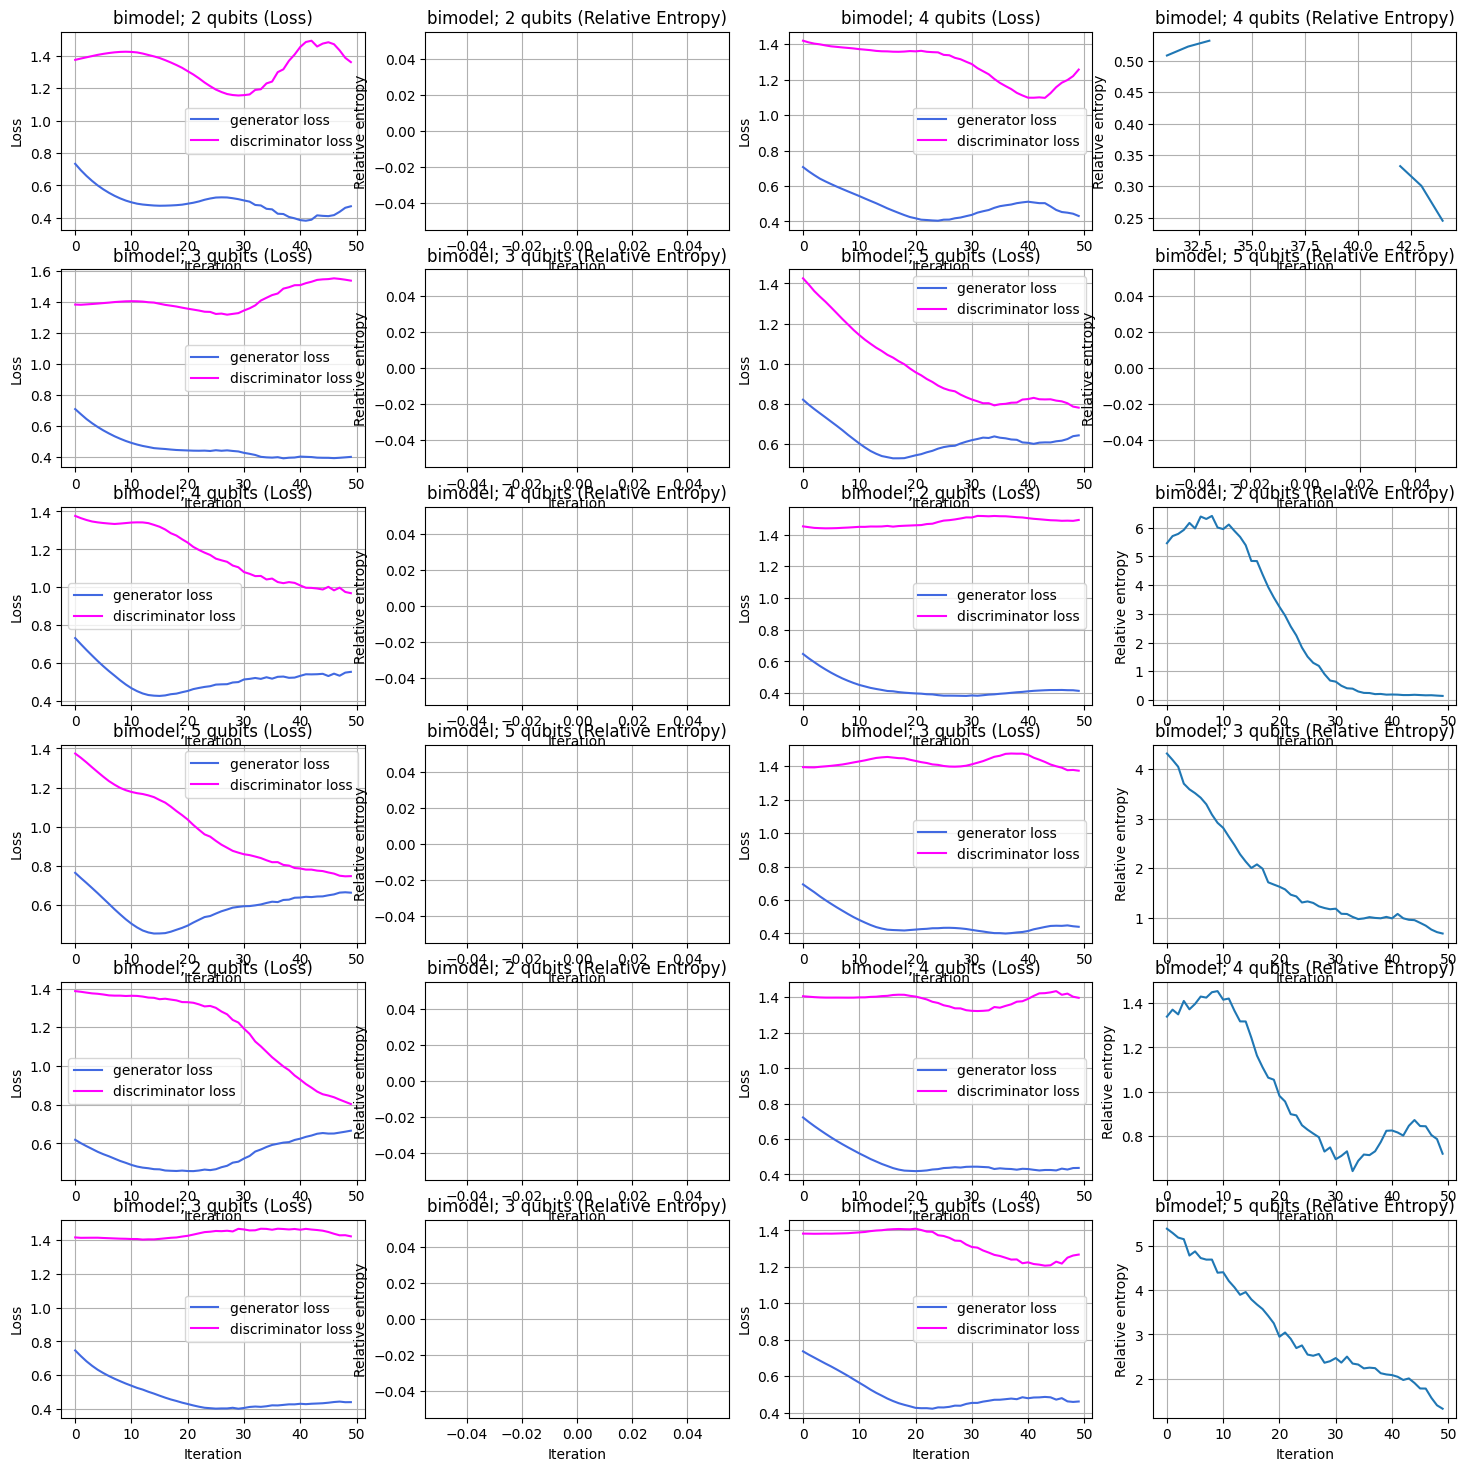

In [17]:
# run training
distributions = ["triangular", "log-normal", "bimodel"]
qbits = range(2,6)
n_epochs = 50 # TODO: maybe tweak this?
num_layers = 3 # TODO: tweak

training_instances = []

for distribution in distributions:
    for num_qubits in qbits:
        print(f"training for case: {distribution}, {num_qubits} qubits") 
        
        training_instance = train(n_epochs, num_qubits, num_layers, distribution)
        training_instance["num_qubits"] = f"{num_qubits}"
        training_instance["distribution"] = f"{distribution}"
        
        training_instances.append(training_instance)
        
plot_values(training_instances)